# How has political sentiment changed over the course of the pandemic?

In [1]:
# Just to keep output tidy - remove later
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import pandas as pd

from src.data_processing import *
from src.plots import *

In [2]:
DATA_PATH = "./data/"

## Grouping Countries by Response

We can imagine that countries can be grouped together based on their response to the COVID pandemic.

From `interventions.csv`, we can calculate how long it took for the first measures to be imposed after the first case in the country, and for how long mobility in the country was reduced. Based on these two measures, we can try to find clusters of countries in order to group them.

In [3]:
# Loading data
df_dates = pd.read_csv(DATA_PATH + "interventions.csv", index_col="lang")
# Processing data
df_dates = process_interventions_data(df_dates)

We calculate the Silhouette Score for different numbers of clusters in order to find the optimal number of clusters.

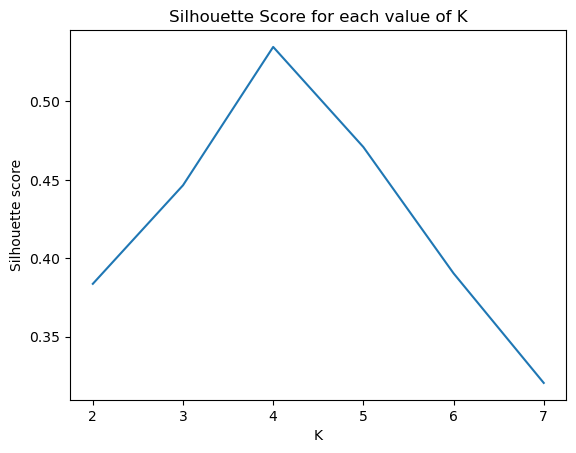

In [4]:
# Select rows where response time and reduced mobility duration are defined
df = df_dates.loc[
    df_dates[["Response time", "Reduced mobility"]].notna().all(1),
    ["Response time", "Reduced mobility"],
]

plot_silhouettes(df, 2, 7)

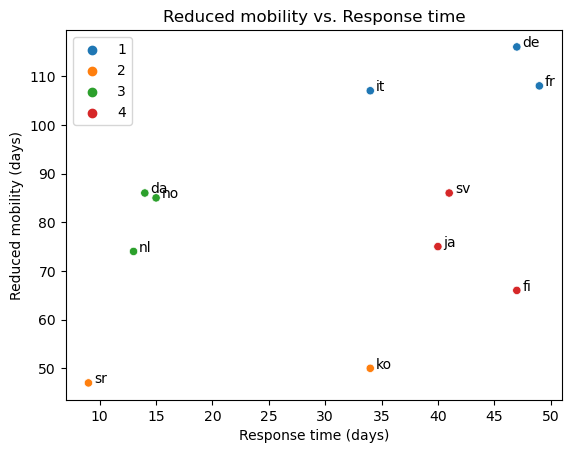

In [5]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(df)

plot_mobility_response(df, kmeans.labels_)

We can identify the following groups of countries:

1. Big European economies which took a long time to react to COVID (possibly due to not wanting to harm the economy) and ended up having long periods of reduced mobility (France, Germany, Italy).

2. Countries with very short periods of reduced mobility (Serbia, South Korea).

3. Smaller highly developed European countries which reacted quickly to COVID and had shorter periods of reduced mobility (Denmark, Netherlands, Norway).

4. Countries which took longer to react to COVID but had shorter periods of reduced mobility (Finland, Japan, Sweden).

Catalan (representing Spain) is the only language besides English to not feature in the plot above. We take a look at its entry in `interventions.csv`.

In [6]:
# Interventions entry for Spain
df_dates.loc["ca"]

1st case                2020-01-31 00:00:00
1st death               2020-02-13 00:00:00
School closure          2020-03-12 00:00:00
Public events banned    2020-03-08 00:00:00
Lockdown                2020-03-14 00:00:00
Mobility                2020-03-16 00:00:00
Normalcy                                NaT
Response time                          37.0
Reduced mobility                        NaN
Name: ca, dtype: object

The response time was not swift relative to other countries. The datapoint is not plotted due to having an undefined duration of the reduced mobility period, since there is no date for the return to normal mobility levels. We can say that the reduced mobility period is also a long one, which would place Spain in group 1 - big European economies with a long response time and long period of reduced mobility.

Our final groups of countries are:

1. France, Germany, Italy, Spain
2. Serbia, South Korea
3. Denmark, Netherlands, Norway
4. Finland, Japan, Sweden